# Barcelona test

## Preparations

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
import esda
from splot.esda import lisa_cluster, moran_scatterplot
from libpysal import graph
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn import cluster

import pandas as pd

In [3]:
link = 'https://opendata-ajuntament.barcelona.cat/data/dataset/d8e40c96-9f1f-4fd3-86da-2baa1599616d/resource/edaf6642-a51b-4b2b-a492-fa913d5e8b91/download/2021_atles_renda_bruta_llar.csv'
gross_income = gpd.read_file(link)

link1 = 'https://opendata-ajuntament.barcelona.cat/data/dataset/147d27cf-13a0-49e4-812e-1decc3cb4736/resource/2405d999-5755-462b-b1e9-7e7dafacb384/download/2021_atles_renda_mediana.csv'
equival_income = gpd.read_file(link1)

children = gpd.read_file('./data/2021_pad_dom_mdbas_edat-0018.csv')

edu = gpd.read_file('./data/2021_pad_mdbas_niv-educa-esta_sexe.csv')

seccio = gpd.read_file('./data/seccio_censal')

ERROR 1: PROJ: proj_create_from_database: Open of /home/marek/miniforge3/envs/sds/share/proj failed


### Data Wrangling

In [4]:
children = children.drop(
    columns=['Data_Referencia',
             'Codi_Barri',
             'Nom_Barri',
             'AEB',
             'geometry',
             'Nom_Districte']
             ).rename(columns={'Codi_Districte': 'district_code',
                               'Seccio_Censal': 'section_code',
                               'Valor': 'households',
                               'DOM_00_18': 'children'
                               }
                               )
children['households'] = children['households'].astype(int)
children['children'] = children['children'].astype(int)

children['district_code_length'] = children['district_code'].str.len()
children['section_code'] = children.apply(
    lambda row: row['section_code'][row['district_code_length']:], axis=1
    )
children = children.drop(columns=['district_code_length'])

children['section_code'] = children['section_code'].astype(int)
children['district_code'] = children['district_code'].astype(int)

children['weighted_children'] = children['children'] * children['households']
grouped = children.groupby(['district_code', 'section_code']).agg(
    total_households=('households', 'sum'),
    total_weighted_children=('weighted_children', 'sum')
)
grouped['average_children'] =(
    grouped['total_weighted_children'] / grouped['total_households']
    )
children = grouped.reset_index().drop(
    columns=['total_weighted_children',
             'total_households'
             ]
             )

children.head()

,district_code,section_code,average_children
0,1,1,1.313840
1,1,2,1.309654
2,1,3,1.439926
3,1,4,1.381341
4,1,5,1.363542


In [5]:
equival_income = equival_income.drop(
    columns=['Any', 'Codi_Barri', 'Nom_Barri', 'geometry', 'Nom_Districte']
    ).rename(columns={'Mediana_Renda_€': 'equival_income',
                      'Codi_Districte': 'district_code',
                      'Seccio_Censal': 'section_code'
                      }
                      )
equival_income['equival_income'] = equival_income['equival_income'].astype(int)
equival_income['district_code'] = equival_income['district_code'].astype(int)
equival_income['section_code'] = equival_income['section_code'].astype(int)
equival_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   district_code   1068 non-null   int64
 1   section_code    1068 non-null   int64
 2   equival_income  1068 non-null   int64
dtypes: int64(3)
memory usage: 25.2 KB


In [6]:
gross_income = gross_income.drop(
    columns=['Any', 'Codi_Barri', 'Nom_Barri', 'geometry']
    ).rename(columns={'Import_Renda_Bruta_€': 'gross_income',
                      'Codi_Districte': 'district_code',
                      'Nom_Districte': 'district_name',
                      'Seccio_Censal': 'section_code',
                      }
                      )
gross_income['section_code'] = gross_income['section_code'].astype(int)
gross_income['district_code'] = gross_income['district_code'].astype(int)
gross_income['gross_income'] = gross_income['gross_income'].astype(float)
gross_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   district_code  1068 non-null   int64  
 1   district_name  1068 non-null   object 
 2   section_code   1068 non-null   int64  
 3   gross_income   1068 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.5+ KB


In [7]:
edu.head()

,Data_Referencia,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,AEB,Seccio_Censal,Valor,NIV_EDUCA_esta,SEXE,geometry
0,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,10,1,1,None
1,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,..,1,2,None
2,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,106,2,1,None
3,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,144,2,2,None
4,2021-01-01,1,Ciutat Vella,1,el Raval,1,1001,108,3,1,None


In [8]:
edu = edu.drop(
    columns=['Data_Referencia',
             'Codi_Barri',
             'Nom_Barri',
             'AEB',
             'geometry',
             'Nom_Districte']
             ).rename(columns={'Codi_Districte': 'district_code',
                               'Seccio_Censal': 'section_code',
                               'Valor': 'people',
                               'NIV_EDUCA_esta': 'education_level',
                               'SEXE': 'gender'
                               }
                               )

edu['district_code_length'] = edu['district_code'].str.len()
edu['section_code'] = edu.apply(
    lambda row: row['section_code'][row['district_code_length']:], axis=1
    )
edu = edu.drop(columns=['district_code_length'])

edu['section_code'] = edu['section_code'].astype(int)
edu['district_code'] = edu['district_code'].astype(int)
edu['people'] = edu['people'].replace('..', np.nan).astype(float)


grouped = edu.groupby([
    'district_code',
    'section_code',
    'education_level',
    'gender'
    ])['people'].sum()

unstacked = grouped.unstack(level=[2, 3])
unstacked.reset_index(inplace=True)
unstacked.fillna(0, inplace=True)

unstacked.columns = ['_'.join(col) for col in unstacked.columns.values]

column_mapping = {
    col: (
        col.replace('_1', '_f')
        .replace('_2', '_m')
        .replace('district_code_', 'district_code')
        .replace('section_code_', 'section_code')
        .replace('1_', 'no_edu_')
        .replace('2_', 'prim_')
        .replace('5_', 'high_')
        .replace('6_', 'no_data_')
        )
        for col in unstacked.columns
}

unstacked.rename(columns=column_mapping, inplace=True)

unstacked['sec_f'] = unstacked['3_f'] + unstacked['4_f']
unstacked['sec_m'] = unstacked['3_m'] + unstacked['4_m']

unstacked = unstacked.drop(columns=['3_f', '4_f', '3_m', '4_m'])

columns_to_move = ['sec_f', 'sec_m']
new_position = 7

original_columns = unstacked.columns.to_list()

for column in columns_to_move:
    original_columns.remove(column)

for column in columns_to_move:
    original_columns.insert(new_position -1, column)
    new_position += 1

edu = unstacked[original_columns]

edu.head()

,district_code,section_code,no_edu_f,no_edu_m,prim_f,prim_m,sec_f,sec_m,high_f,high_m,no_data_f,no_data_m
0,1,1,10.0,0.0,106.0,144.0,214.0,309.0,177.0,188.0,9.0,0.0
1,1,2,21.0,6.0,126.0,185.0,279.0,338.0,189.0,174.0,11.0,5.0
2,1,3,31.0,19.0,366.0,520.0,539.0,750.0,303.0,306.0,30.0,39.0
3,1,4,20.0,10.0,249.0,339.0,490.0,696.0,387.0,368.0,14.0,21.0
4,1,5,29.0,10.0,237.0,318.0,399.0,519.0,312.0,273.0,17.0,25.0


In [9]:
seccio = seccio[['DISTRICTE', 'SEC_CENS', 'geometry']]
seccio = seccio.rename(columns={
    'DISTRICTE': 'district_code',
    'SEC_CENS': 'section_code'
    }
    )

seccio['district_code'] = seccio['district_code'].astype(int)
seccio['section_code'] = seccio['section_code'].astype(int)

seccio.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   district_code  1068 non-null   int64   
 1   section_code   1068 non-null   int64   
 2   geometry       1068 non-null   geometry
dtypes: geometry(1), int64(2)
memory usage: 25.2 KB


#### Merging

In [10]:
for df in [children, equival_income, gross_income, edu]:
    seccio = seccio.merge(df, on=['district_code', 'section_code'])

seccio.head()

,district_code,section_code,geometry,average_children,equival_income,district_name,gross_income,no_edu_f,no_edu_m,prim_f,prim_m,sec_f,sec_m,high_f,high_m,no_data_f,no_data_m
0,1,5,"POLYGON ((430905.031 4581350.072, 430938.474 4...",1.363542,11550,Ciutat Vella,27950.0,29.0,10.0,237.0,318.0,399.0,519.0,312.0,273.0,17.0,25.0
1,1,6,"POLYGON ((430874.963 4581396.929, 430870.976 4...",1.318108,11550,Ciutat Vella,33086.0,10.0,6.0,128.0,187.0,269.0,384.0,211.0,244.0,6.0,10.0
2,1,7,"POLYGON ((430614.207 4581309.336, 430622.668 4...",1.419771,12250,Ciutat Vella,32945.0,10.0,0.0,148.0,311.0,296.0,498.0,220.0,231.0,7.0,10.0
3,1,8,"POLYGON ((430564.164 4581104.412, 430550.048 4...",1.509542,10150,Ciutat Vella,26200.0,21.0,10.0,360.0,686.0,507.0,795.0,221.0,252.0,20.0,34.0
4,1,9,"POLYGON ((430275.270 4581082.530, 430331.870 4...",1.433850,11550,Ciutat Vella,30306.0,13.0,6.0,224.0,298.0,382.0,462.0,241.0,260.0,11.0,10.0


## Exploration

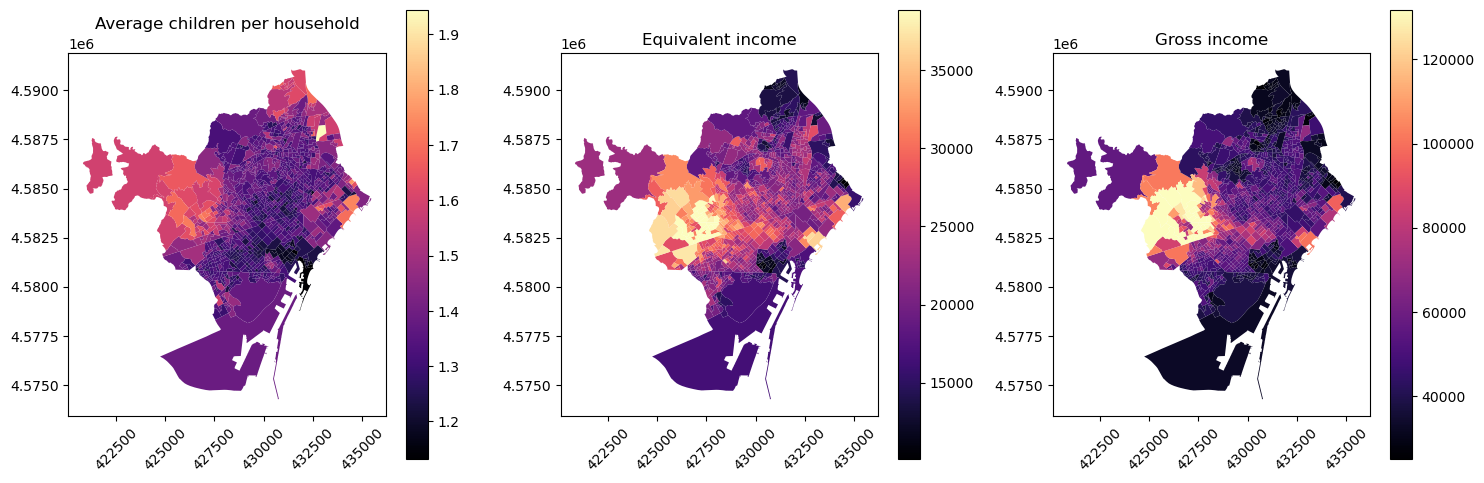

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

seccio.plot(column='average_children', ax=ax[0], legend=True, cmap='magma')
seccio.plot(column='equival_income', ax=ax[1], legend=True, cmap='magma')
seccio.plot(column='gross_income', ax=ax[2], legend=True, cmap='magma')

ax[0].set_title('Average children per household')
ax[1].set_title('Equivalent income')
ax[2].set_title('Gross income')

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

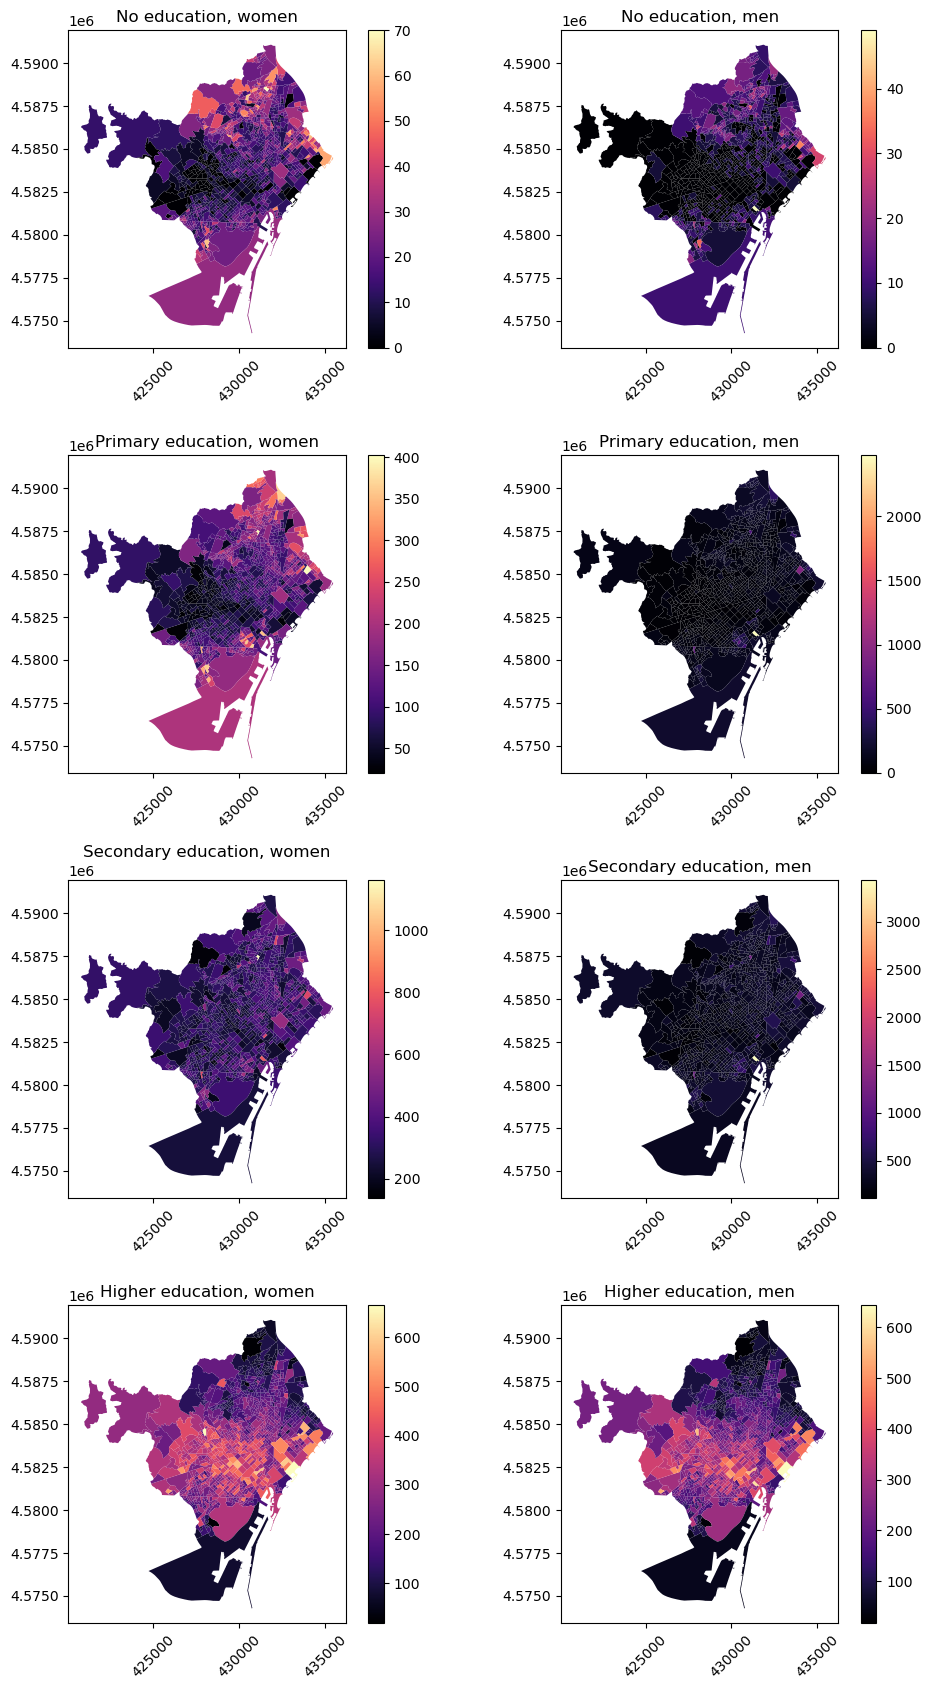

In [12]:
fig, ax = plt.subplots(4, 2, figsize=(10,17))

seccio.plot(column='no_edu_f', ax=ax[0, 0], legend=True, cmap='magma')
seccio.plot(column='no_edu_m', ax=ax[0, 1], legend=True, cmap='magma')
seccio.plot(column='prim_f', ax=ax[1, 0], legend=True, cmap='magma')
seccio.plot(column='prim_m', ax=ax[1, 1], legend=True, cmap='magma')
seccio.plot(column='sec_f', ax=ax[2, 0], legend=True, cmap='magma')
seccio.plot(column='sec_m', ax=ax[2, 1], legend=True, cmap='magma')
seccio.plot(column='high_f', ax=ax[3, 0], legend=True, cmap='magma')
seccio.plot(column='high_m', ax=ax[3, 1], legend=True, cmap='magma')

ax[0, 0].set_title('No education, women')
ax[0, 1].set_title('No education, men')
ax[1, 0].set_title('Primary education, women')
ax[1, 1].set_title('Primary education, men')
ax[2, 0].set_title('Secondary education, women')
ax[2, 1].set_title('Secondary education, men')
ax[3, 0].set_title('Higher education, women')
ax[3, 1].set_title('Higher education, men')

ax[0, 0].tick_params(axis='x', rotation=45)
ax[0, 1].tick_params(axis='x', rotation=45)
ax[1, 0].tick_params(axis='x', rotation=45)
ax[1, 1].tick_params(axis='x', rotation=45)
ax[2, 0].tick_params(axis='x', rotation=45)
ax[2, 1].tick_params(axis='x', rotation=45)
ax[3, 0].tick_params(axis='x', rotation=45)
ax[3, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

### LISA

In [13]:
contiguity = graph.Graph.build_contiguity(seccio, rook=False)
contiguity_r = contiguity.transform("r")

lisa = esda.Moran_Local(seccio['gross_income'], contiguity_r.to_W())

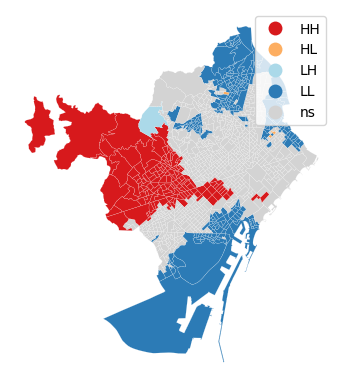

In [14]:
_ = lisa_cluster(lisa, seccio)

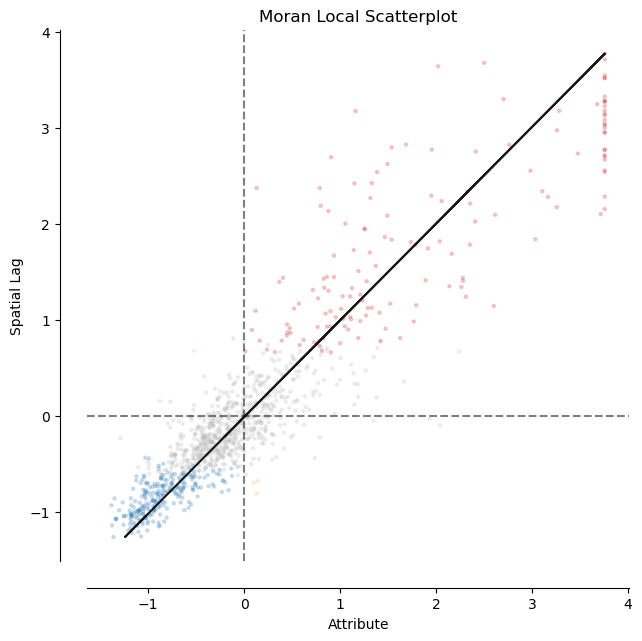

In [15]:
_ = moran_scatterplot(lisa, p=0.05, scatter_kwds={"s": 5, "alpha":.2})

## Clustering

### Preparation

/home/marek/miniforge3/envs/sds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marek/miniforge3/envs/sds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marek/miniforge3/envs/sds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marek/miniforge3/envs/sds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

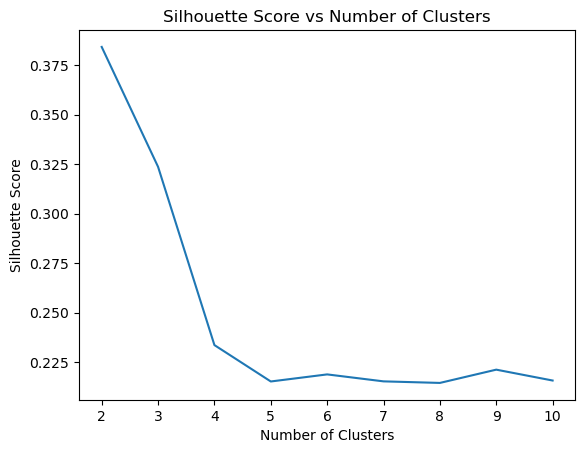

In [16]:
subranks = [
    'average_children', 'gross_income',
    'high_f', 'sec_f', 'prim_f', 'no_edu_f',
    ]

scaler = RobustScaler()
data_scaled = scaler.fit_transform(seccio[subranks])

scores = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(data_scaled)
    scores.append(silhouette_score(data_scaled, kmeans.labels_))

plt.plot(range(2, 11), scores)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [17]:
optimal_clusters = 4

#### KMeans

In [18]:
kmeans4 = cluster.KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans4.fit(data_scaled)
seccio['kmeans4'] = kmeans4.labels_

/home/marek/miniforge3/envs/sds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Spatially-lagged cluster

In [19]:
queen = graph.Graph.build_contiguity(seccio)
queen_r = queen.transform("r")

for column in subranks:
    seccio[column + "_lag"] = queen_r.lag(seccio[column])

subranks_lag = [column + "_lag" for column in subranks]
subranks_spatial = subranks + subranks_lag

data_scaled_spatial = scaler.fit_transform(seccio[subranks_spatial])

kmeans4_lag = cluster.KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans4_lag.fit(data_scaled_spatial)
seccio['kmeans4_lag'] = kmeans4_lag.labels_

/home/marek/miniforge3/envs/sds/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Regionalisation

In [20]:
agg4 = cluster.AgglomerativeClustering(n_clusters=optimal_clusters, connectivity=queen.sparse)
agg4.fit(data_scaled)
seccio['agg4'] = agg4.labels_

### Visualisation

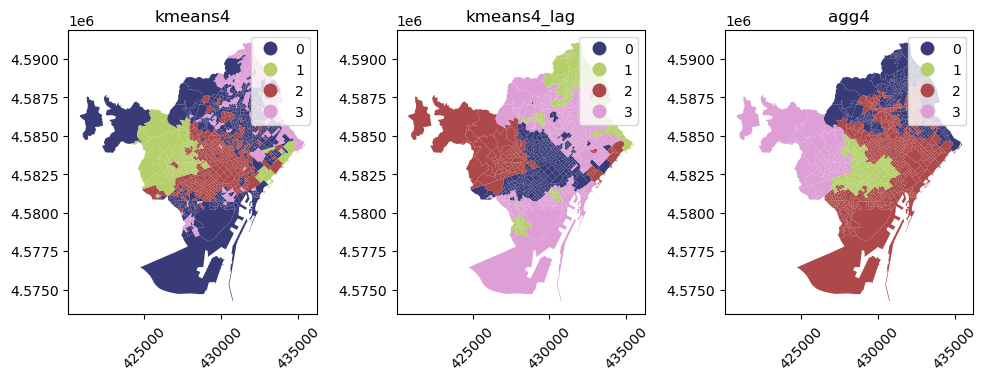

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(10, 18))
seccio.plot(column='kmeans4', ax=ax[0], legend=True, categorical=True, cmap='tab20b')
seccio.plot(column='kmeans4_lag', ax=ax[1], legend=True, categorical=True, cmap='tab20b')
seccio.plot(column='agg4', ax=ax[2], legend=True, categorical=True, cmap='tab20b')

ax[0].set_title('kmeans4')
ax[1].set_title('kmeans4_lag')
ax[2].set_title('agg4')

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Scaled data visualisation

In [28]:
men = [column for column in seccio.columns if '_m' in column]
men_scaled = [column + "_scaled" for column in men]

scaled_values = scaler.fit_transform(seccio[men])

seccio[men_scaled] = pd.DataFrame(scaled_values)

<Axes: >

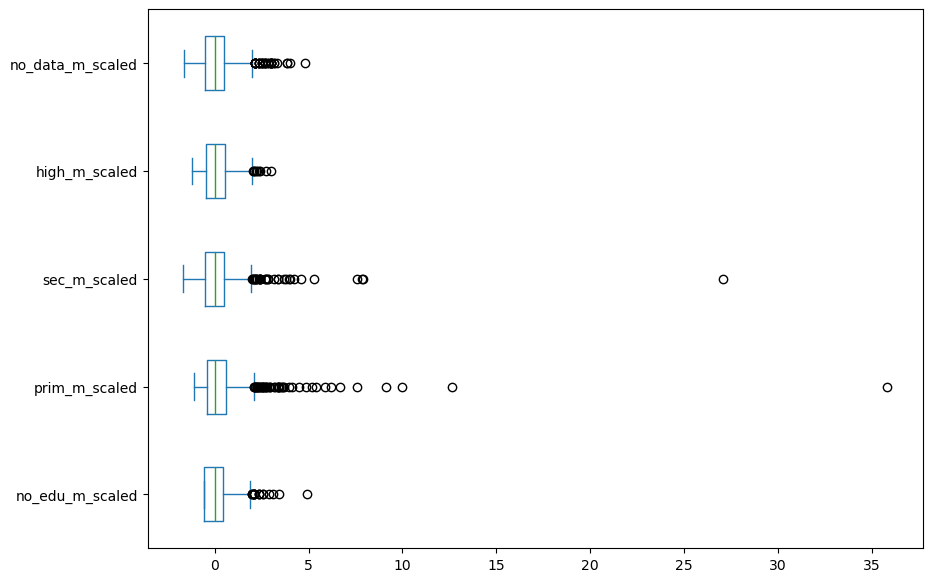

In [31]:
seccio[men_scaled].plot(kind='box', vert=False, figsize=(10, 7))

In [32]:
seccio[men_scaled].head()

,no_edu_m_scaled,prim_m_scaled,sec_m_scaled,high_m_scaled,no_data_m_scaled
0,0.555556,3.641791,1.809111,0.515050,2.5
1,0.111111,1.686567,0.637744,0.321070,0.0
2,-0.555556,3.537313,1.626898,0.234114,0.0
3,0.555556,9.134328,4.203905,0.374582,4.0
4,0.111111,3.343284,1.314534,0.428094,0.0


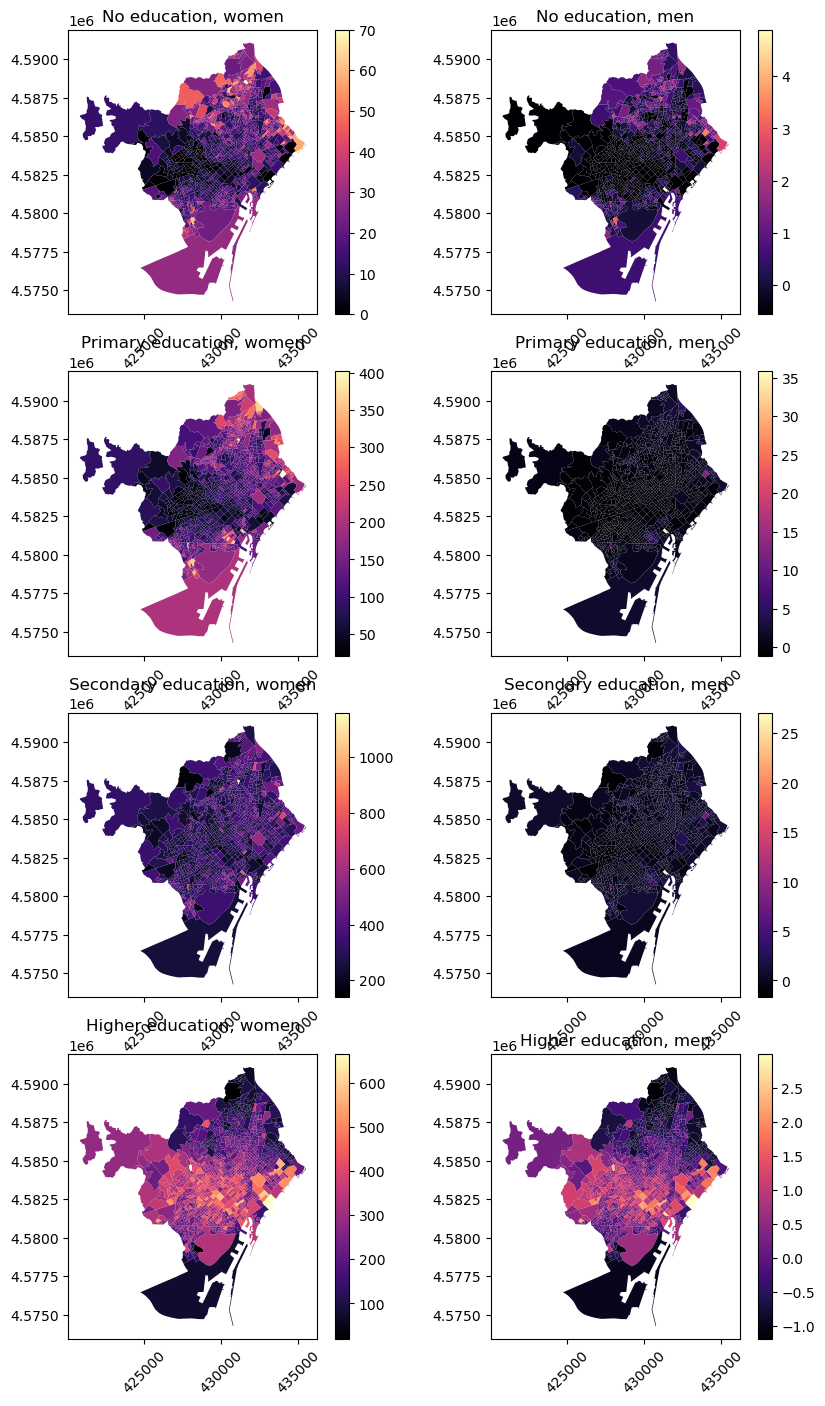

In [33]:
fig, ax = plt.subplots(4, 2, figsize=(10,17))

seccio.plot(column='no_edu_f', ax=ax[0, 0], legend=True, cmap='magma')
seccio.plot(column='no_edu_m_scaled', ax=ax[0, 1], legend=True, cmap='magma')
seccio.plot(column='prim_f', ax=ax[1, 0], legend=True, cmap='magma')
seccio.plot(column='prim_m_scaled', ax=ax[1, 1], legend=True, cmap='magma')
seccio.plot(column='sec_f', ax=ax[2, 0], legend=True, cmap='magma')
seccio.plot(column='sec_m_scaled', ax=ax[2, 1], legend=True, cmap='magma')
seccio.plot(column='high_f', ax=ax[3, 0], legend=True, cmap='magma')
seccio.plot(column='high_m_scaled', ax=ax[3, 1], legend=True, cmap='magma')

ax[0, 0].set_title('No education, women')
ax[0, 1].set_title('No education, men')
ax[1, 0].set_title('Primary education, women')
ax[1, 1].set_title('Primary education, men')
ax[2, 0].set_title('Secondary education, women')
ax[2, 1].set_title('Secondary education, men')
ax[3, 0].set_title('Higher education, women')
ax[3, 1].set_title('Higher education, men')

ax[0, 0].tick_params(axis='x', rotation=45)
ax[0, 1].tick_params(axis='x', rotation=45)
ax[1, 0].tick_params(axis='x', rotation=45)
ax[1, 1].tick_params(axis='x', rotation=45)
ax[2, 0].tick_params(axis='x', rotation=45)
ax[2, 1].tick_params(axis='x', rotation=45)
ax[3, 0].tick_params(axis='x', rotation=45)
ax[3, 1].tick_params(axis='x', rotation=45)
